# Author identification

В этом ноутбуке содержится код для экспериментов для решения задачи кластеризации текстов по авторам.
Для простоты используется датасет CVL, который уже поделен на слова

In [1]:
import os
import pathlib

from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam, SGD
import pytorch_lightning as pl
import torchvision

from sklearn.cluster import KMeans

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt


from typing import Dict, Any, Tuple, List, Optional

/Users/danmishin/opt/anaconda3/envs/native/lib/python3.11/site-packages/torch/distributed/_shard/partial_tensor.py:40: UserWarning: Please use DTensor instead and we are deprecating ShardedTensor.
  warnings.warn(DEPRECATE_MSG)
/Users/danmishin/opt/anaconda3/envs/native/lib/python3.11/site-packages/torch/distributed/_shard/replicated_tensor.py:20: UserWarning: Please use DTensor instead and we are deprecating ShardedTensor.
  warnings.warn(DEPRECATE_MSG)


In [2]:
ROOT_PATH = "/Users/danmishin/DataspellProjects/DiplomaProject/cvl-database-1-1"
DATASET_PATH = os.path.join(ROOT_PATH, "MERGED")
SLICES_PATH = os.path.join(ROOT_PATH, "SLICES")

DEBUG = False

# Dataset

В этом ноутбуке используется датасет CVL. Код датасета можно найти в папке `dataset_preprocessing` рядом с этим ноутбуком.
Переменная `DATASET_PATH` содержит путь к папке, в которой содержатся все картинки **слов** из датасета (на моем компьютере она называется `MERGED`). 

In [3]:
from dataset_preprocessing.handwriting_dataset import CVLHandwritingWordsDataset
cvl_dataset = CVLHandwritingWordsDataset(DATASET_PATH, debug=DEBUG)
print(f"Number of word images: {len(cvl_dataset)}")

Number of word images: 99904


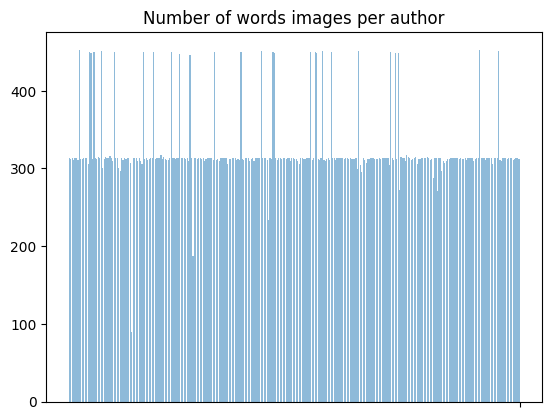

In [4]:
author_dist = cvl_dataset.get_distribution()

plt.bar(list(author_dist.keys()), author_dist.values(), alpha=0.5)
plt.title("Number of words images per author")
plt.xticks("")
plt.show()

Как мы видим, для каждого автора примерно одинаковое количество картинок. Потому что в этом датасете они писали одни и те же тексты

# Preprocessing

Хотим найти ключевые моменты изображения с помощью corner detector (назовем их слайсами)

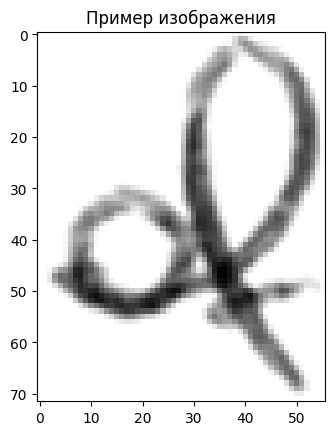

In [21]:
plt.imshow(cvl_dataset[52]["image_tensor"], cmap='gray')
plt.title("Пример изображения")
pass

In [22]:
def distance(first, second):
    return (first[0] - second[0])**2 + (first[1] - second[1])**2

def filter_keypoints(kp, threshold=1.0):
    """
    Функция фильтрации ключевых точек. Если они находятся
    близко друг к другу, то только одна из них попадет
    в финальный список
    """
    not_close_coords = []
    
    for coord in kp:
        bad = False
        for another in not_close_coords:
            if distance(coord.pt, another.pt) < threshold ** 2:
                bad = True
                break
        if not bad:
            not_close_coords.append(coord)
            
    return not_close_coords

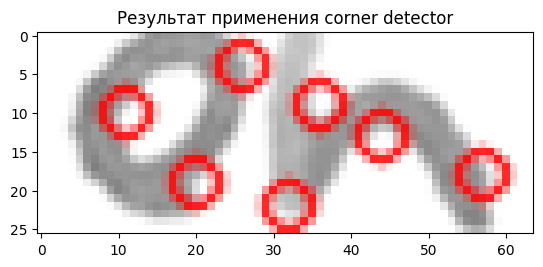

In [23]:
# Пример картинки
image = cvl_dataset[42]["image_tensor"]

def apply_FAST(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    fast = cv.FastFeatureDetector_create(threshold=50)
    kp = fast.detect(gray, None)
    kp = filter_keypoints(kp, 8)
    return kp

kp = apply_FAST(image)

image_with_kp = cv.drawKeypoints(image, kp, None, (255, 0, 0))
plt.title("Результат применения corner detector")
plt.imshow(image_with_kp)
pass

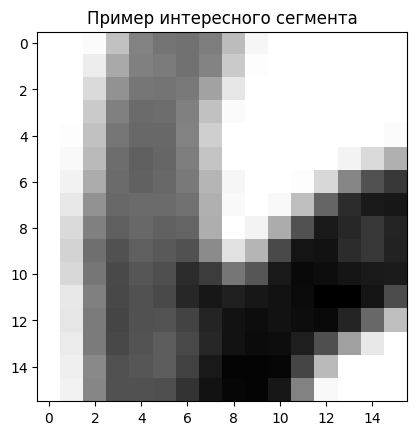

In [24]:
def extract_rectangle(image: np.ndarray, coordinate: Tuple[int, int], size=16):
    """
    Функция извлечения квадрата размера (size x size) с центром в точке coordinate.
    """
    
    # coordinate: (x, y)
    x0 = max(0, coordinate[0] - size // 2)
    y0 = max(0, coordinate[1] - size // 2)
    x1 = min(image.shape[1] - 1, coordinate[0] + size // 2)
    y1 = min(image.shape[0] - 1, coordinate[1] + size // 2)

    slice = np.copy(image[int(y0):int(y1), int(x0):int(x1)])

    if coordinate[0] < size // 2:
        pad = np.ones((slice.shape[0], size - slice.shape[1])) * 255
        slice = np.hstack((pad, slice))

    if coordinate[0] + size // 2 > image.shape[1] - 1:
        pad = np.ones((slice.shape[0], size - slice.shape[1])) * 255
        slice = np.hstack((slice, pad))

    if coordinate[1] < size // 2:
        pad = np.ones((size - slice.shape[0], slice.shape[1])) * 255
        slice = np.vstack((pad, slice))

    if coordinate[1] + size // 2 > image.shape[0] - 1:
        pad = np.ones((size - slice.shape[0], slice.shape[1])) * 255
        slice = np.vstack((slice, pad))

    return slice

def slice_image_with_kp(image: np.ndarray, kp: List[Any]):
    return [extract_rectangle(image, kp[i].pt) for i in range(len(kp))]

key_segments = slice_image_with_kp(image, kp)
plt.title("Пример интересного сегмента")
plt.imshow(key_segments[1], cmap='gray')
pass

In [25]:
def generate_slice_dataset(dataset: CVLHandwritingWordsDataset):
    """
    Функция генерации слайсов. Так как их может образоваться много,
    то мы сохраняем их на диск в папку SLICES_PATH
    """
    global_id = 0

    files = glob(os.path.join(SLICES_PATH, "*"))
    for file in tqdm(files):
        os.remove(file)

    for datapoint in tqdm(dataset):
        image = datapoint["image_tensor"]
        key_points = apply_FAST(image)
        slices = slice_image_with_kp(image, key_points)

        for slice in slices:
            slice = (255 - slice)
            global_id += 1
            filename = f"{datapoint['author_id']}-{datapoint['text_id']}-{global_id}.png"
            cv.imwrite(os.path.join(SLICES_PATH, filename), slice)

# Раскомменть эту строчку для генерации слайсов
#generate_slice_dataset(cvl_dataset)

# Slices Dataset

После этого был создан отдельный датасет для слайсов. Его код также можно увидеть в папке `dataset_preprocessing`

In [27]:
from dataset_preprocessing.slice_dataset import SlicesDataset

In [28]:
slices_dataset = SlicesDataset(SLICES_PATH, debug=DEBUG)

In [30]:
print("Number of slices:", len(slices_dataset))

Number of slices: 1806017


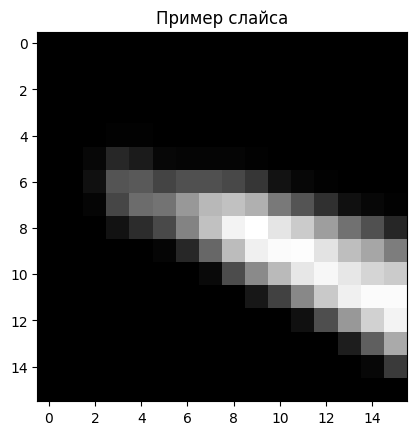

In [31]:
image = slices_dataset[42]["image"]
plt.imshow(image, cmap='gray')
plt.title("Пример слайса")
pass

# Model 1: Autoencoder + VLAD + KMeans

Unsupervised метод кластеризации, который работает следующим образом

1) Обучаем автоэнкодер на слайсах, чтобы уметь доставать эмбеддинги. Автоэнкодер по архитектуре напоминает отзеркаленный vgg.
2) Потом для кластеризации текстов достаем из них слайсы, прогоняем через автоэнкодер и получаем эмбеддинги
3) Эти эмбеддинги мы объединяет в глобальный вектор с помощью метода VLAD
4) Глобальные эмбеддинги в итоге кластеризуем и получаем кластеризацию по авторам изображений

In [32]:
from torch.utils.data import DataLoader, random_split

batch_size = 128

train_size = int(0.8 * len(slices_dataset))
test_size = len(slices_dataset) - train_size

train_dataset, test_dataset = random_split(slices_dataset, [train_size, test_size])

val_size = int(0.1 * train_size)
train_size = train_size - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8)

## AutoEncoder

In [33]:
class AutoEncoder(pl.LightningModule):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2)
            ),
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2)
            ),
            nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2)
            ),
            nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2)
            ),
        )

        self.decoder = nn.Sequential(
            nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(1),
                nn.Sigmoid()
            ),
        )

        self.criterion = nn.MSELoss()

    def forward(self, x):
        embedding = self.encoder(x)
        return embedding
    
    def put_through(self, x):
        embedding = self.encoder(x)
        decoded = self.decoder(embedding)
        return decoded

    def configure_optimizers(self):
        return SGD(self.parameters(), lr=1e-4, momentum=0.9)

    def training_step(self, train_batch, batch_idx):
        images = train_batch["image"]
        images = images[:, None, :, :]

        output = self.decoder(self.encoder(images))
        loss = self.criterion(output, images)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images = val_batch["image"]
        images = images[:, None, :, :]

        output = self.decoder(self.encoder(images))
        loss = self.criterion(output, images)
        self.log("val_loss", loss)
        return {
            "loss": loss,
            "images": (images, output)
        }
    
    def validation_epoch_end(self, outputs):
        tensorboard = self.logger.experiment
        
        images, output = outputs[0]["images"]
        info = torch.cat((images, output))
        
        grid_images = torchvision.utils.make_grid(info)
        tensorboard.add_image('val_result', grid_images, self.current_epoch)

In [34]:
model = AutoEncoder()

trainer = pl.Trainer(
    accelerator='gpu', 
    max_epochs=15,
    #resume_from_checkpoint = AUTOENCODER_PATH
)

# Раскоменьть, если хочешь обучать
# trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [35]:
# Загрузить уже готовую модель
AUTOENCODER_PATH = os.path.join(ROOT_PATH, "..", "lightning_logs/version_83/checkpoints/epoch=14-step=152385.ckpt")
model = AutoEncoder.load_from_checkpoint(AUTOENCODER_PATH)
model.train(False)

pass

Text(0.5, 1.0, 'Результат работы модели')

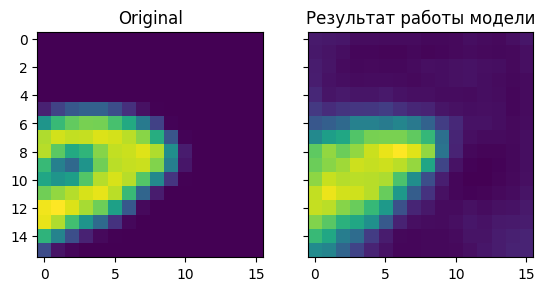

In [38]:
x = test_dataset[42]["image"][None, None, :, :]
result = model.put_through(x).detach().numpy()

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(x[0][0])
ax1.set_title("Original")
ax2.imshow(result[0][0])
ax2.set_title("Autoencoder result")
plt.title("Результат работы модели")

## VLAD vectors

Эмпирическим путем выявлено, что оптимальный уровень PCA ~85.
А количество кластеров для VLAD: 4
(Возможно фиксировать эти значения очень плохо)

Ниже приведен код для эксперементов. Используется elbow метод для определения количества кластеров.

In [43]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

def get_number_of_clusters(embeddings: torch.Tensor) -> torch.Tensor:
    embeddings = nn.functional.normalize(embeddings)
    embeddings = embeddings.detach().numpy()
    
    pca = PCA(n_components = 0.95)
    pca.fit(embeddings)
    embeddings = pca.transform(embeddings)
    
    model = KMeans(n_init=10)
    visualizers = [
        KElbowVisualizer(model, k=(2,15), metric='silhouette', locate_elbow=True),
        KElbowVisualizer(model, k=(2,15), metric='distortion', locate_elbow=True),
        KElbowVisualizer(model, k=(2,15), metric='calinski_harabasz', locate_elbow=True)        
    ]
    
    results = []
    
    for visualizer in visualizers:
        visualizer.fit(embeddings)
        visualizer.show()
        results.append(visualizer.elbow_value_)
        
    results = np.array(results)
    values, counts = np.unique(results, return_counts=True)
    return results[np.argmax(counts)]

Эксперемент:

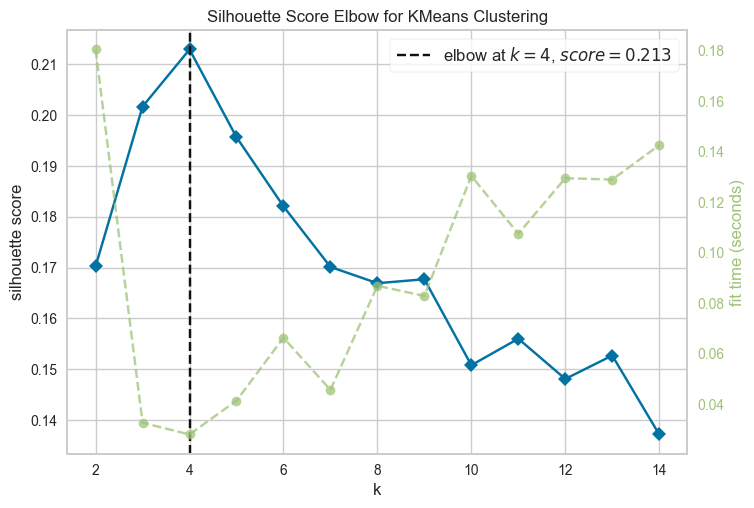

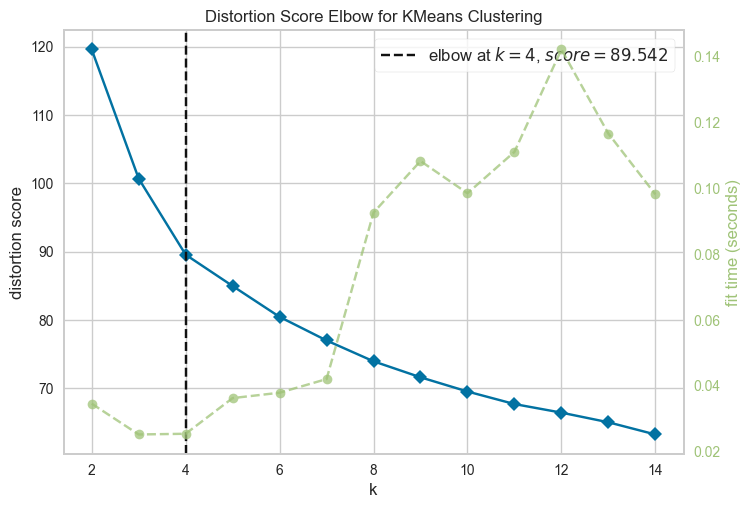

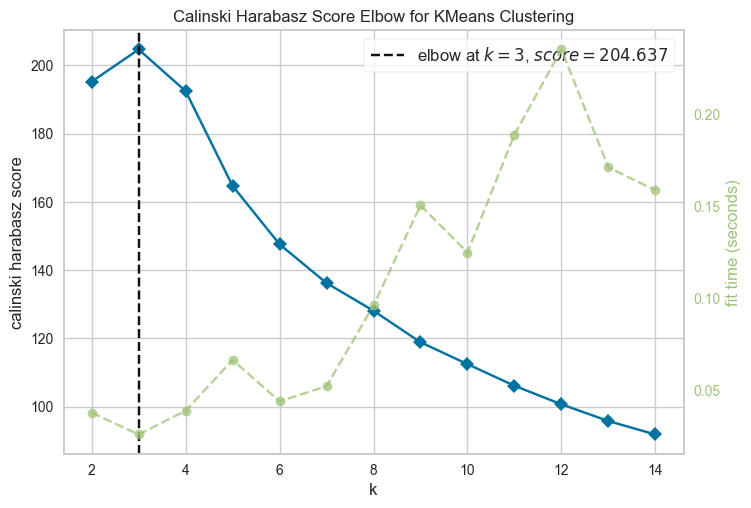

Optimal value of clusters: 4


In [46]:
AUTHOR_ID = 6  # try [1..6]
TEXT_ID = 2    # try [1..8]

text_sample = slices_dataset.get_author_text(AUTHOR_ID, TEXT_ID)["images"][:, None, :, :]
embeddings = model.forward(text_sample).squeeze()
opt = get_number_of_clusters(embeddings)
print("Optimal value of clusters: {}".format(opt))

In [51]:
def get_vlad(embeddings: torch.Tensor, pca_num=85, vlad_k_means=4) -> np.ndarray:
    """
    Функция получения VLAD вектора
    из эмбеддингов слайсов изображения
    """
    embeddings = nn.functional.normalize(embeddings)
    embeddings = embeddings.detach().numpy()
    
    pca = PCA(n_components = pca_num)
    pca.fit(embeddings)
    embeddings = pca.transform(embeddings)
    
    k_means = KMeans(n_init=10, n_clusters=vlad_k_means)
    k_means.fit(embeddings)
    
    vlad = np.zeros((pca_num, vlad_k_means))
    for i, cluster_center in enumerate(k_means.cluster_centers_):
        vlad[:, i] = cluster_center
    
    for i, embedding in enumerate(embeddings):
        cluster_id = k_means.labels_[i]
        vlad[:, cluster_id] -= embedding
        
    return vlad

## K-Means
Теперь возьмем для эксперемента 6 авторов. Они написали 8 одинаковых текстов. Сгенерируем для них всех VLAD вектора

In [52]:
NUM_OF_AUTHORS = 6
NUM_OF_TEXTS = 8

vlads = []
for author_id in range(1, NUM_OF_AUTHORS + 1):
    print("Author: {}".format(author_id))
    for text_id in tqdm(range(1, NUM_OF_TEXTS + 1)):
        text_sample = slices_dataset.get_author_text(6, 2)["images"][:, None, :, :]
        embeddings = model.forward(text_sample).squeeze()
        vlad = get_vlad(embeddings).flatten()
        vlads.append(vlad)
        
vlads = np.array(vlads)

Author: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.46s/it]


Author: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.49s/it]


Author: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.45s/it]


Author: 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.57s/it]


Author: 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.58s/it]


Author: 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.58s/it]


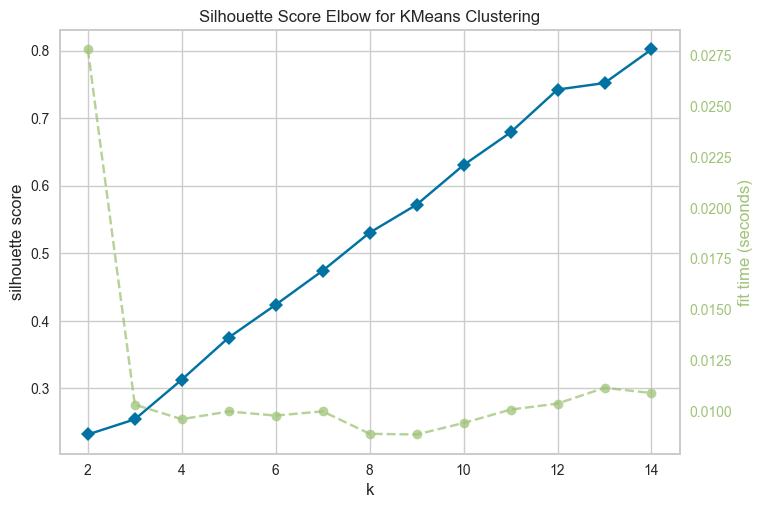

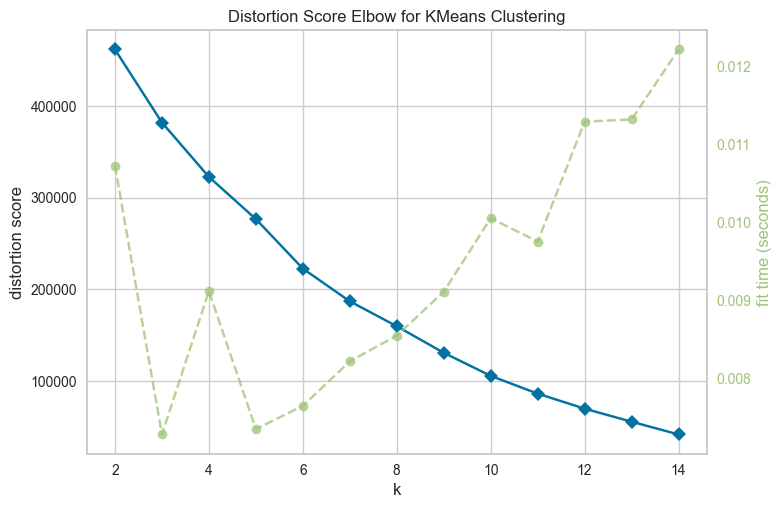

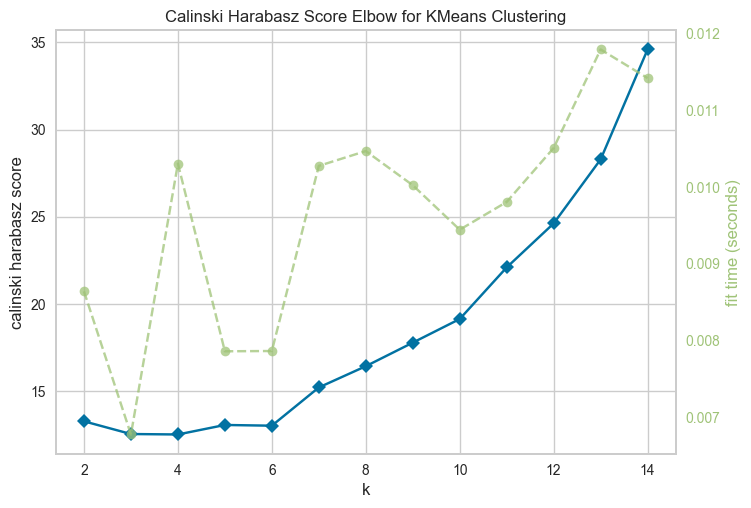

In [53]:
def visualize_number_of_clusters(vlads: np.ndarray):
    model = KMeans(n_init=10)
    visualizers = [
        KElbowVisualizer(model, k=(2,15), metric='silhouette', locate_elbow=False),
        KElbowVisualizer(model, k=(2,15), metric='distortion', locate_elbow=False),
        KElbowVisualizer(model, k=(2,15), metric='calinski_harabasz', locate_elbow=False)        
    ]
    
    for visualizer in visualizers:
        visualizer.fit(vlads)
        visualizer.show()

visualize_number_of_clusters(vlads)

Как мы видим, "elbow" довольно-таки сложно найти :(